In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.integrate import quad

In [3]:
G = 1

In [4]:
filename = "isolation.hdf5"
f = h5py.File(filename, "r")
partmass = f["/PartType1/Masses"][0]
PartIDs = np.copy(f["/PartType1/ParticleIDs"][:])

x = np.copy(f["/PartType1/Coordinates"][:, 0])
y = np.copy(f["/PartType1/Coordinates"][:, 1])
z = np.copy(f["/PartType1/Coordinates"][:, 2])
vx = np.copy(f["/PartType1/Velocities"][:, 0])
vy = np.copy(f["/PartType1/Velocities"][:, 1])
vz = np.copy(f["/PartType1/Velocities"][:, 2])

N = len(x)

In [5]:
x -= np.mean(x)
y -= np.mean(y)
z -= np.mean(z)
vx -= np.mean(vx)
vy -= np.mean(vy)
vz -= np.mean(vz)

In [6]:
r = np.sqrt(x**2 + y**2 + z**2)

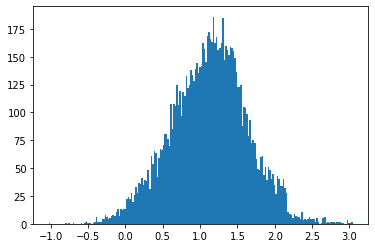

In [7]:
plt.hist(np.log10(r), 200);

Text(0, 0.5, 'y')

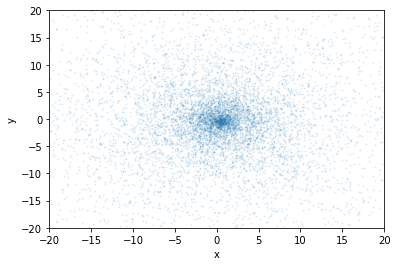

In [11]:
plt.scatter(x, y, s=1, alpha=0.1)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.xlabel("x")
plt.ylabel("y")

In [12]:
Mr = partmass * np.arange(N)

In [13]:
Ekin = 1/2 * (vx**2 + vy**2 + vz**2)

In [14]:
sortedr   = np.sort(r)
reverser  = sortedr[::-1]
SortIdx   = np.argsort(r)
UnsortIdx = np.argsort(SortIdx)
Phi       =  - G*  ( Mr / sortedr + np.cumsum(partmass / reverser )[::-1] )
Etot      = Phi[UnsortIdx] + Ekin

In [15]:
filt = Etot < 0

In [16]:
pi = np.pi

In [17]:
def rhoS(r) :   
    return np.exp(-(r/rsS)**(1/n))
n  = 1
rsS = 0.308 # 

MS  = 4 * pi * quad( lambda r: r*r * rhoS(r) , 0., np.inf)[0] # non-normalized total stellar mass
MSr = np.vectorize(lambda x: 4*pi *  quad( lambda r: r*r * rhoS(r)/MS , 0., x  )[0]  )

In [18]:
EN     = 100
DFNr   = 100
DFrmax = np.max(r)
DFrmin = np.min(r)
EPSREL = 1e-7

In [46]:
DFr    = np.logspace(np.log10(DFrmin),np.log10(DFrmax),num=DFNr)

NoutS =   1. - 4. * pi * quad( lambda r: r*r * rhoS(r)/MS , 0., DFrmax)[0]
NinS  =        4. * pi * quad( lambda r: r*r * rhoS(r)/MS , 0., DFrmin)[0]
print("     (!) Stars: there are %.2f per cent < DRrmin "%NinS )
print("     (!) and %.2f per cent > DFrmax "%NoutS )


     (!) Stars: there are 0.00 per cent < DRrmin 
     (!) and 0.00 per cent > DFrmax 


In [20]:
psi  = - np.interp(DFr, sortedr, Phi)
nuDM, edges = np.histogram(r, bins=np.logspace(np.log10(DFrmin),np.log10(DFrmax),num=DFNr+1) )
nuDM        = nuDM * partmass  / ( 4./3 * pi * ((edges[1:])**3 - (edges[:-1])**3 )  )
nuS  =   rhoS(DFr) / MS

In [21]:
Mcum  = np.interp(DFr, sortedr, Mr)  # DM cumulative mass on array
MScum = MSr(DFr)               # stellar cumulative mass on array


/tmp/ipykernel_6834/1769840033.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DFr), np.log10(nuDM), color="red", label = "DM")
/tmp/ipykernel_6834/1769840033.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DFr), np.log10(nuS),  color="blue", label = "stars")


(-20.0, 0.0)

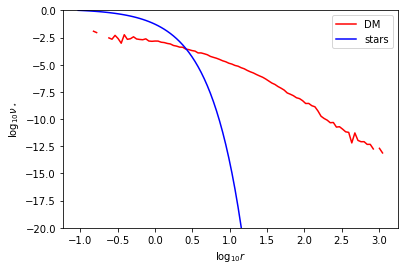

In [22]:
plt.plot(np.log10(DFr), np.log10(nuDM), color="red", label = "DM")
plt.plot(np.log10(DFr), np.log10(nuS),  color="blue", label = "stars")
plt.xlabel ("$\\log_{10} r$")
plt.ylabel ("$\\log_{10} \\nu_\\star$")
plt.legend()
plt.ylim(-20, 0)

Text(0, 0.5, '$\\Phi(r)$')

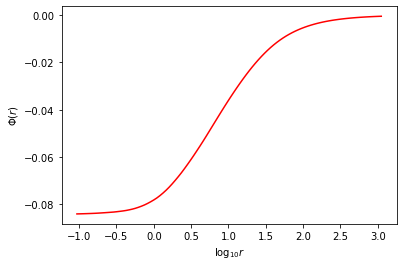

In [23]:
plt.plot(np.log10(DFr), -psi, color="red", label = "DM")
plt.xlabel ("$\\log_{10} r$")
plt.ylabel ("$\\Phi(r)$")

In [24]:
dndpDM   = np.gradient(nuDM,   psi)
d2nd2pDM = np.gradient(dndpDM, psi)
dndpS   = np.gradient(nuS,   psi)
d2nd2pS = np.gradient(dndpS, psi)

In [25]:
less_than_one = np.where (Mcum < 1.0 - float(1./N) )[0]
less_than_one_idx = np.argmax(Mcum >= 1.0)

In [26]:
fS  = np.vectorize( lambda e: 1./(np.sqrt(8)*pi*pi) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pS[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(e)   == 0 due to B.C.
fDM = np.vectorize( lambda e: 1./(np.sqrt(8)*pi*pi) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pDM[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(e)   == 0 due to B.C.

In [27]:
maxE = psi[0]
minE = maxE/float(EN)
E = np.linspace(minE,maxE,num=EN)

In [28]:
DFS = fS(E)

/tmp/ipykernel_6834/2729620021.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fS  = np.vectorize( lambda e: 1./(np.sqrt(8)*pi*pi) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pS[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(e)   == 0 due to B.C.


In [29]:
DFDM = fDM(E)

/tmp/ipykernel_6834/2729620021.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fDM = np.vectorize( lambda e: 1./(np.sqrt(8)*pi*pi) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pDM[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(e)   == 0 due to B.C.
/tmp/ipykernel_6834/2729620021.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  fDM = np.vectorize( lambda e: 1./(np.sqrt(8)*pi*pi) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pDM[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np

In [30]:
DFDM

array([-4.77738209e-08,  4.03541156e-08,  1.87797922e-07,  3.25180554e-06,
        1.70015816e-06,  3.75255783e-06,  5.98292923e-06,  6.74503940e-06,
        9.02141845e-06,  1.74862628e-05,  2.95248939e-05,  3.14876702e-05,
        3.68445731e-05,  4.65455627e-05,  5.53033301e-05,  7.62885747e-05,
        1.03307962e-04,  1.26593415e-04,  1.29991152e-04,  1.26383379e-04,
        1.23975725e-04,  1.44238220e-04,  1.74693217e-04,  1.99352213e-04,
        2.17266029e-04,  2.27117858e-04,  2.62689927e-04,  3.31274274e-04,
        3.90957335e-04,  4.36858667e-04,  4.67492800e-04,  4.82873670e-04,
        4.93122259e-04,  5.01011344e-04,  5.09677404e-04,  5.24674417e-04,
        5.47315900e-04,  6.08233345e-04,  6.90721897e-04,  7.98211226e-04,
        9.22876862e-04,  1.04987960e-03,  1.18470425e-03,  1.31622479e-03,
        1.43819766e-03,  1.55673654e-03,  1.73632182e-03,  1.96847711e-03,
        2.18428786e-03,  2.27462637e-03,  2.30474219e-03,  2.27617837e-03,
        2.20957798e-03,  

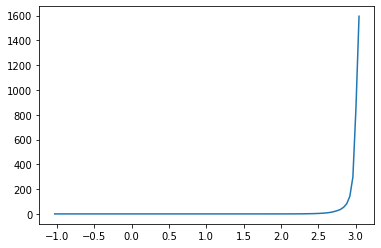

In [50]:
plt.plot(np.log10(DFr), (DFS),)

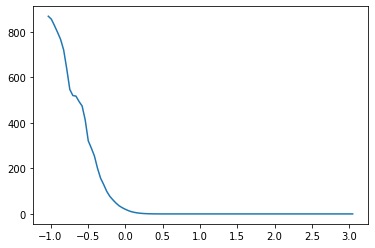

In [53]:
plt.plot(np.log10(DFr), np.log10(dr)

/tmp/ipykernel_6834/1181501910.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(E), np.log10(DFS))


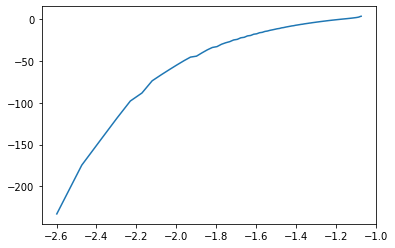

In [55]:
plt.plot(np.log10(E), np.log10(DFS))

/tmp/ipykernel_6834/809161053.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(E), np.log10(DFDM))


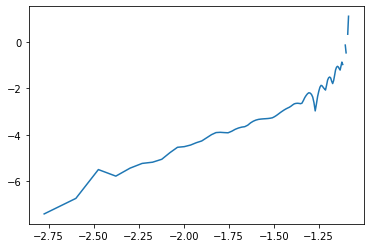

In [54]:
plt.plot(np.log10(E), np.log10(DFDM))

In [32]:
probs = np.interp(-Etot, E, DFS)/ np.interp(-Etot, E, DFDM)
probs = probs/np.sum(probs[~np.isnan(probs)])

In [33]:
nuS_Nbody, edges = np.histogram(r, weights=probs, bins=np.logspace(np.log10(DFrmin),np.log10(DFrmax),num=DFNr+1) )
nuS_Nbody        = nuS_Nbody  / ( 4./3 * pi * ((edges[1:])**3 - (edges[:-1])**3 )  )

/tmp/ipykernel_6834/3950216239.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DFr), np.log10(nuS), color="blue", linewidth=2, linestyle="dashed", label = "stars (analyt.)")
/tmp/ipykernel_6834/3950216239.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DFr), np.log10(nuS_Nbody),  color="fuchsia", label = "stars (N-body)")
/tmp/ipykernel_6834/3950216239.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(DFr), np.log10(nuS_Nbody),  color="fuchsia", label = "stars (N-body)")


(-30.0, 16.177085910914283)

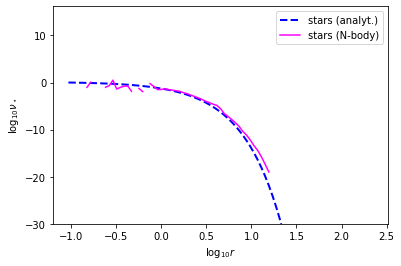

In [57]:
plt.plot(np.log10(DFr), np.log10(nuS), color="blue", linewidth=2, linestyle="dashed", label = "stars (analyt.)")
plt.plot(np.log10(DFr), np.log10(nuS_Nbody),  color="fuchsia", label = "stars (N-body)")
plt.xlabel ("$\\log_{10} r$")
plt.ylabel ("$\\log_{10} \\nu_\\star$")
plt.legend()
plt.ylim(-30)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.800e+01,
        9.977e+03, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.46768861, -0.39430418, -0.32091975, -0.24753532, -0.17415089,
        -0.10076646, -0.02738202,  0.04600241,  0.11938684,  0.19277127,
         0.2661557 ,  0.33954013,  0.41292456,  0.48630899,  0.55969342,
         0.63307785,  0.70646228,  0.77984671,  0.85323114,  0.92661557,
         1.        ]),
 <BarContainer object of 20 artists>)

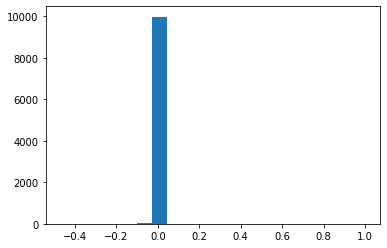

In [35]:
plt.hist(probs / np.max(probs), 20)